In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm


import math

os.environ["CUDA_VISIBLE_DEVICES"]="2"

gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## dataset read and processing

this is the same as ben's original notebook, pretty much

In [3]:
features_sig=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
features_bg2=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [4]:
features_sig

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


In [7]:
alpha = 0.1

def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labels = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", r"$\tau_{2,1}^{J_2}$"
]


In [8]:
dataset_bg=load_data(features_bg)
dataset_bg2=load_data(features_bg2)
dataset_sig=load_data(features_sig)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [9]:
dataset_bg_more=load_data_more(features_bg)
dataset_bg2_more=load_data_more(features_bg2)
dataset_sig_more=load_data_more(features_sig)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

(array([1.99501796e-04, 1.46538819e-03, 7.60956849e-03, 2.68234914e-02,
        6.82699894e-02, 1.32554693e-01, 2.10909023e-01, 2.71804571e-01,
        3.08080648e-01, 3.17806360e-01, 3.09196908e-01, 2.72726080e-01,
        2.09830763e-01, 1.33547452e-01, 6.83174899e-02, 2.64696132e-02,
        7.83044547e-03, 1.42026278e-03, 1.37751240e-04]),
 array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
        -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
         0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
         2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ]),
 <a list of 19 Patch objects>)

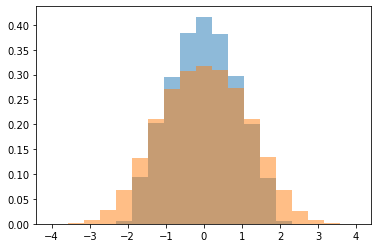

In [10]:
plt.hist(dataset_sig_more[:,9],density=True,alpha=0.5,bins=np.linspace(-4,4,20))
plt.hist(dataset_bg_more[:,9],density=True,alpha=0.5,bins=np.linspace(-4,4,20))

## data preparation

making it machine-learnable, setting params for ML methods, setting signal significance

In [11]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsb, bg2_srsb, sig_srsb = sr_crit(dataset_bg), sr_crit(dataset_bg2), sr_crit(dataset_sig)

SR_background_data = dataset_bg[bg_srsb]
SB_background_data = dataset_bg[~bg_srsb]

SR_background_sim = dataset_bg2[bg2_srsb]
SB_background_sim = dataset_bg2[~bg2_srsb]

SR_signal = dataset_sig[sig_srsb]
SB_signal = dataset_sig[~sig_srsb]

N_inputs = len(SR_background_data.T) - 1


((SR_background_data, SR_background_data_fortest),
 (SR_background_sim, SR_background_sim_fortest),
 (SB_background_data, SB_background_data_fortest),
 (SB_background_sim, SB_background_sim_fortest),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_data, SR_background_sim,
    SB_background_data, SB_background_sim,
]]

mn,mx = np.percentile(np.concatenate([SB_background_data, SB_background_sim, SR_background_data, 
                                      SR_background_sim]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signal)*Nsig/len(SR_signal)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signal[0:Nsig])/len(SR_background_data)**0.5))
print(fmt.format('s/b ratio', len(SR_signal[0:Nsig])/len(SR_background_data)))

n_injections = 20
SR_signals_to_inject = [None] * n_injections
SB_signals_to_inject = [None] * n_injections
signals_to_test = [None] * n_injections

for i in range(n_injections):
    idx = np.isin(range(len(SR_signal)), np.random.choice(SR_signal.shape[0], size=Nsig, replace=False))
    SR_signals_to_inject[i] = SR_signal[idx, :]
    signals_to_test[i] = SR_signal[~idx, :]
    
    idx = np.isin(range(len(SB_signal)), np.random.choice(SB_signal.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_inject[i] = SB_signal[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


## Fully supervised

1-d cases are both m1 and m2

In [13]:
#First, let's do fully supervised

Nsig_each = int(len(SR_signal)/2)

SR_sig_draw = np.random.permutation(SR_signal)
X_sup_train = np.concatenate([SR_sig_draw[:Nsig_each,1:],SR_background_data[:,1:]])
Y_sup_train = np.concatenate([np.ones(len(SR_sig_draw[:Nsig_each,1:])),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_sig_draw[Nsig_each:,1:],SR_background_data_fortest[:,1:]])
Y_sup_val = np.concatenate([np.ones(len(SR_sig_draw[Nsig_each:,1:])),np.zeros(len(SR_background_data_fortest))])

model_sup = Sequential()
model_sup.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=1)

scores_sup = model_sup.predict(X_sup_val,batch_size=batch_size,verbose=0)
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/20
98325/98325 [==============================] - 3s 28us/step - loss: 0.3676 - acc: 0.8443
Epoch 2/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.3095 - acc: 0.8766
Epoch 3/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2994 - acc: 0.8824
Epoch 4/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2958 - acc: 0.8836
Epoch 5/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2938 - acc: 0.8850
Epoch 6/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2898 - acc: 0.8865
Epoch 7/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2804 - acc: 0.8898
Epoch 8/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2649 - acc: 0.8967
Epoch 9/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2533 - acc: 0.9019
Epoch 10/20
98325/98325 [==============================] - 2s 24us/step - loss: 0.2453 - acc: 0.9051

## Autoencoder

In [18]:
dataset_bg_inSR = dataset_bg[sr_crit(dataset_bg)]
dataset_sig_inSR = dataset_sig[sr_crit(dataset_sig)]

In [39]:
ae_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    X_ae_train = dataset_bg_inSR[0:int(0.5*len(dataset_bg_inSR)),1:]
    X_ae_val = np.concatenate([dataset_bg_inSR[int(0.5*len(dataset_bg_inSR)):, 1:],
                               dataset_sig_inSR[:, 1:]])
    Y_ae_val = np.concatenate([np.zeros(len(dataset_bg_inSR[int(0.5*len(dataset_bg_inSR)):, 1:])),
                               np.ones(len(dataset_sig_inSR[:, 1:]))])
    
    model_ae = Sequential()
    model_ae.add(Dense(64, input_dim=4, activation='relu'))
    #model_ae.add(Dense(64, activation='relu'))
    model_ae.add(Dense(2, activation='relu'))
    model_ae.add(Dense(64, activation='relu'))
    #model_ae.add(Dense(64, activation='relu'))
    model_ae.add(Dense(4, activation='linear'))
    model_ae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    hist_ae = model_ae.fit(X_ae_train, X_ae_train, epochs=EPOCHS, 
                           batch_size=batch_size, verbose=0)  
    
    ae_save_folder = 'models/autoencoder/'
    if not os.path.exists(ae_save_folder):
        os.makedirs(ae_save_folder)
    model_ae.save('models/autoencoder/model_%i'%i)
    
    scores_ae = model_ae.predict(X_ae_val,batch_size=batch_size,verbose=0)
    mses_ae = np.linalg.norm(scores_ae-X_ae_val,axis=1)
    
    if (False):
        plt.hist(mses_ae[Y_sup_train==0],bins=np.linspace(0,1,20),alpha=0.5,label="Background",density=True)
        plt.hist(mses_ae[Y_sup_train==1],bins=np.linspace(0,1,20),alpha=0.5,label="Signal",density=True)
        plt.xlabel("MSE")
        plt.legend(frameon=False)
        
    fpr_ae, tpr_ae, _ = roc_curve(Y_ae_val, mses_ae)
    ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)

100%|██████████| 20/20 [14:58<00:00, 44.94s/it]


In [22]:
np.shape(dataset_bg_more)

(999999, 10)

In [42]:
dataset_bg_more_inSR = dataset_bg_more[sr_crit(dataset_bg_more)]
dataset_sig_more_inSR = dataset_sig_more[sr_crit(dataset_sig_more)]

In [43]:
X_ae_train = dataset_bg_more_inSR[0:int(0.5*len(dataset_bg_more_inSR))]
X_ae_val = np.concatenate([dataset_bg_more_inSR[int(0.5*len(dataset_bg_more_inSR)):],dataset_sig_more_inSR])
Y_ae_val = np.concatenate([np.zeros(len(dataset_bg_more_inSR[int(0.5*len(dataset_bg_more_inSR)):])),np.ones(len(dataset_sig_more_inSR))])

In [44]:
#bigger model

tpr_fpr_ae_more = []

for i in tqdm.tqdm(range(10)):
    
    model_ae = Sequential()
    model_ae.add(Dense(64, input_dim=10, activation='relu')) 
    #model_ae.add(Dense(64, activation='relu'))
    model_ae.add(Dense(2, activation='relu'))
    model_ae.add(Dense(64, activation='relu'))
    #model_ae.add(Dense(64, activation='relu'))
    model_ae.add(Dense(10, activation='linear'))
    model_ae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    hist_ae = model_ae.fit(X_ae_train,X_ae_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)  
    
    scores_ae = model_ae.predict(X_ae_val,batch_size=batch_size,verbose=0)
    mses_ae = np.linalg.norm(scores_ae-X_ae_val,axis=1)
        
    fpr_ae, tpr_ae, _ = roc_curve(Y_ae_val, mses_ae)
    tpr_fpr_ae_more+=[[fpr_ae,tpr_ae]]

100%|██████████| 10/10 [07:35<00:00, 45.50s/it]


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


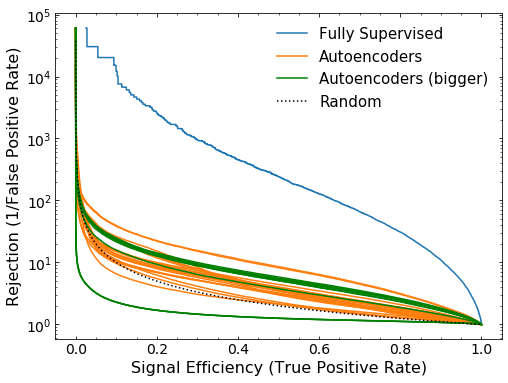

In [47]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(tpr_sup,1./fpr_sup,label="Fully Supervised")

for i, row in ae_rocs.iterrows():
    
    fpr, tpr = row
    
    if (i ==0):
        plt.plot(tpr,1./fpr,label="Autoencoders",color="tab:orange")
    else:
        plt.plot(tpr,1./fpr,color="tab:orange")
        
for i in range(len(tpr_fpr_ae_more)):
    
    if (i ==0):
        plt.plot(tpr_fpr_ae_more[i][1],1./tpr_fpr_ae_more[i][0],label="Autoencoders (bigger)",color="green")
    else:
        plt.plot(tpr_fpr_ae_more[i][1],1./tpr_fpr_ae_more[i][0],color="green")

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")
plt.yscale("log")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")

In [64]:
from sklearn import metrics
for i in range(len(tpr_fpr_ae)):
    print(i,metrics.auc(tpr_fpr_ae[i][0], tpr_fpr_ae[i][1]),metrics.auc(tpr_fpr_ae_more[i][0], tpr_fpr_ae_more[i][1]))

0 0.6464880926385691 0.7271159296652792
1 0.6839524760738784 0.7623421084247057
2 0.6548751057702158 0.7173255766993738
3 0.6446604074899054 0.2648140738992074
4 0.6660301471264424 0.7519584707874167
5 0.59866006311099 0.265658869616387
6 0.5256998701593396 0.7076516020295309
7 0.6011684925752658 0.7656623482244538
8 0.6020717093403851 0.26580948592575354
9 0.6209357204516472 0.2647581117125916


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


(0, 2)

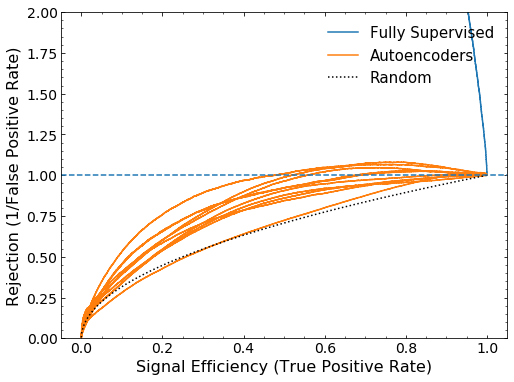

In [14]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(tpr_sup,tpr_sup/fpr_sup**0.5,label="Fully Supervised")

for i in range(len(tpr_fpr_ae)):
    
    if (i ==0):
        plt.plot(tpr_fpr_ae[i][1],tpr_fpr_ae[i][1]/tpr_fpr_ae[i][0]**0.5,label="Autoencoders",color="tab:orange")
    else:
        plt.plot(tpr_fpr_ae[i][1],tpr_fpr_ae[i][1]/tpr_fpr_ae[i][0]**0.5,color="tab:orange")

plt.plot(tpr_sup,tpr_sup/tpr_sup**0.5,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.axhline(1,ls="--")
plt.ylim([0,2])

## Fully supervised, partial feature set

In [7]:
from keras import backend as K
import tqdm

tpr_fpr_sup_1d = []

for i in tqdm.tqdm(range(4)):
    
    K.clear_session()
    model_sup1d = Sequential()
    model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
    model_sup1d.add(Dense(64, activation='relu'))
    model_sup1d.add(Dense(64, activation='relu'))
    model_sup1d.add(Dense(1, activation='sigmoid'))
    model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_sup = model_sup1d.fit(X_sup_train[:,i], Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)

    this_scores_sup1d = model_sup1d.predict(X_sup_val[:,i],batch_size=batch_size)
    this_fpr_sup1d, this_tpr_sup1d, _ = roc_curve(Y_sup_val, this_scores_sup1d)
    tpr_fpr_sup_1d.append([this_tpr_sup1d, this_fpr_sup1d])
    del model_sup1d

100%|██████████| 4/4 [02:46<00:00, 41.53s/it]


In [15]:
from keras import backend as K
import tqdm

tpr_fpr_sup_3d = []

for i in tqdm.tqdm(range(4)):
    
    K.clear_session()
    model_sup3d = Sequential()
    model_sup3d.add(Dense(64, input_dim=3, activation='relu')) 
    model_sup3d.add(Dense(64, activation='relu'))
    model_sup3d.add(Dense(64, activation='relu'))
    model_sup3d.add(Dense(1, activation='sigmoid'))
    model_sup3d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_sup = model_sup3d.fit(X_sup_train[:,np.arange(X_sup_train.shape[1]) != i], Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)

    this_scores_sup3d = model_sup3d.predict(X_sup_val[:,np.arange(X_sup_train.shape[1]) != i],batch_size=batch_size)
    this_fpr_sup3d, this_tpr_sup3d, _ = roc_curve(Y_sup_val, this_scores_sup3d)
    tpr_fpr_sup_3d.append([this_tpr_sup3d, this_fpr_sup3d])
    del model_sup3d

100%|██████████| 4/4 [02:47<00:00, 41.91s/it]


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


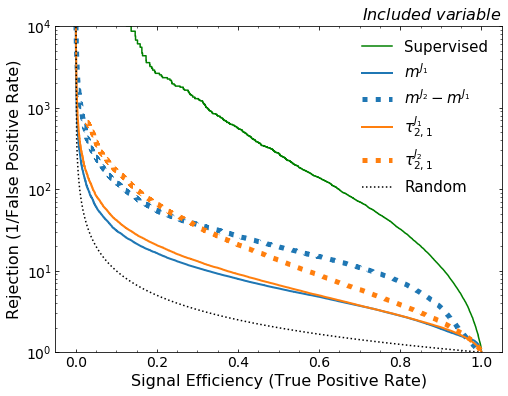

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


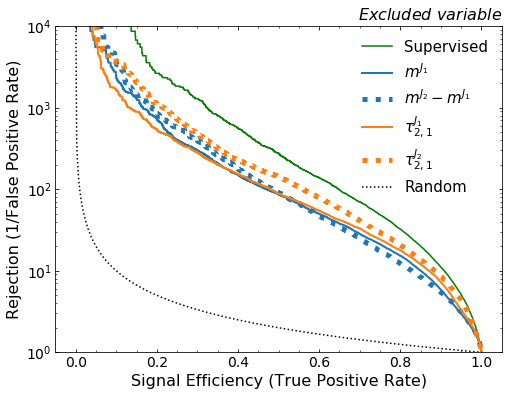

In [26]:
# Plot with banding
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']
lss = ['-', ':', '-', ':']
lww = [2, 5, 2, 5]
for i,(label,(tpr,fpr)) in enumerate(zip(column_labels[1:], tpr_fpr_sup_1d)):
    
    plt.plot(tpr,1./fpr,label=label, ls=lss[i], color=colors[i], linewidth=lww[i]) #color='green',ls=":",linewidth=5)
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.title('$Included~variable$', loc='right', fontsize=16)
plt.savefig('plots/lhco/supervised_deltamj_extracorr.pdf', bbox_inches='tight')
plt.savefig('plots/lhco/supervised_deltamj_extracorr.png', bbox_inches='tight')
plt.show()
# Plot with banding
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']
lss = ['-', ':', '-', ':']
lww = [2, 5, 2, 5]
for i,(label,(tpr,fpr)) in enumerate(zip(column_labels[1:], tpr_fpr_sup_3d)):
    
    plt.plot(tpr,1./fpr,label=label, ls=lss[i], color=colors[i], linewidth=lww[i]) #color='green',ls=":",linewidth=5)
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.title('$Excluded~variable$', fontsize=16, loc='right')
plt.savefig('plots/lhco/supervised3d_deltamj_extracorr.pdf', bbox_inches='tight')
plt.savefig('plots/lhco/supervised3d_deltamj_extracorr.png', bbox_inches='tight')

# SALAD

In [21]:
#Next is SALAD
SALAD_rocs = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injections)):
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]
    signal_to_test = signals_to_test[i]
    
    n_data_sb = len(SB_background_sim) - len(SB_signal_to_inject)
    n_data_sr = len(SR_background_sim) - len(SR_signal_to_inject)

    X_SALAD_sb_train = np.concatenate([SB_background_sim, SB_background_data[np.random.choice(len(SB_background_data), n_data_sb, replace=False)], SB_signal_to_inject])
    Y_SALAD_sb_train = np.concatenate([np.zeros(len(SB_background_sim)), np.ones(n_data_sb), np.ones(len(SB_signal_to_inject))])
    
    sbmjj = X_SALAD_sb_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

    X_SALAD_sb_train = X_SALAD_sb_train[sb_crit]
    Y_SALAD_sb_train = Y_SALAD_sb_train[sb_crit]
    
    N_sb_low = (X_SALAD_sb_train[Y_SALAD_sb_train == 1][:,0] <= SR_low).sum()    
    N_sb_high = (X_SALAD_sb_train[Y_SALAD_sb_train == 1][:,0] >= SR_high).sum()    
    w_low = 0.5*(len(SR_signal_to_inject) + n_data_sr)/((SB_signal_to_inject[:,0] <= SR_low).sum() + N_sb_low)
    w_high = 0.5*(len(SR_signal_to_inject) + n_data_sr)/((SB_signal_to_inject[:,0] >= SR_high).sum() + N_sb_high)
    
    W_SALAD_sb_train = np.ones_like(Y_SALAD_sb_train)
    W_SALAD_sb_train[X_SALAD_sb_train[:,0]<=SR_low] *= w_low
    W_SALAD_sb_train[X_SALAD_sb_train[:,0]>=SR_high] *= w_high
    
    
    X_SALAD_sr_train = np.concatenate([SR_signal_to_inject, SR_background_sim, SR_background_data[np.random.choice(len(SR_background_data), n_data_sr, replace=False)]])
    Y_SALAD_sr_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.zeros(len(SR_background_sim)), np.ones(n_data_sr)])
    
    X_SALAD_sb_train, Y_SALAD_sb_train, W_SALAD_sb_train = shuffle(X_SALAD_sb_train, Y_SALAD_sb_train, W_SALAD_sb_train)
    X_SALAD_sr_train, Y_SALAD_sr_train = shuffle(X_SALAD_sr_train, Y_SALAD_sr_train)
    
    X_SALAD_val = np.concatenate([signal_to_test, SR_background_data_fortest])
    Y_SALAD_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_SALAD_sb = Sequential()
    model_SALAD_sb.add(Dense(64, input_dim=N_inputs + 1, activation='relu')) 
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(1, activation='sigmoid'))
    model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

    hist_SALAD_sb = model_SALAD_sb.fit(
        X_SALAD_sb_train, Y_SALAD_sb_train, epochs=EPOCHS,
        batch_size=batch_size,
        verbose=0, sample_weight=W_SALAD_sb_train
    )

    def get_weights(data, model):
        yhat = model.predict(data, batch_size=int(0.1*len(data)))
        return np.squeeze(yhat/(1 - yhat))

    # apply weight function
    W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
    W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(X_SALAD_sr_train[Y_SALAD_sr_train == 0], model_SALAD_sb)

    # run discriminating model
    model_SALAD_sr = Sequential()
    model_SALAD_sr.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(1, activation='sigmoid'))
    model_SALAD_sr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_SALAD_sr = model_SALAD_sr.fit(
        X_SALAD_sr_train[:, 1:], Y_SALAD_sr_train, epochs=EPOCHS,
        batch_size=batch_size, verbose=0,
        sample_weight=W_SALAD_sr_train
    )

    scores_SALAD = model_SALAD_sr.predict(X_SALAD_val[:, 1:], batch_size=batch_size)

    fpr_SALAD, tpr_SALAD, _ = roc_curve(Y_SALAD_val, scores_SALAD)
    SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)

100%|██████████| 20/20 [46:18<00:00, 138.91s/it]


## plot features w/ reweighting

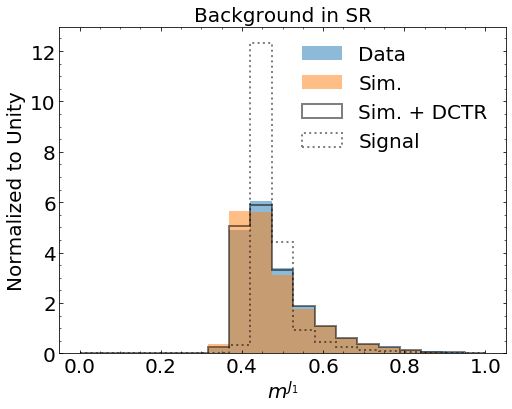

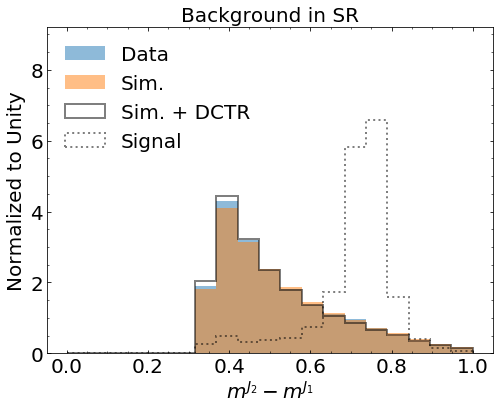

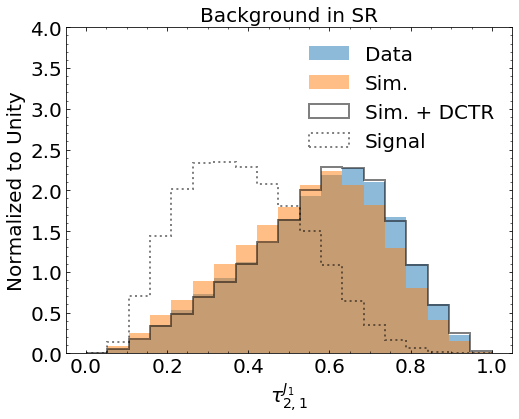

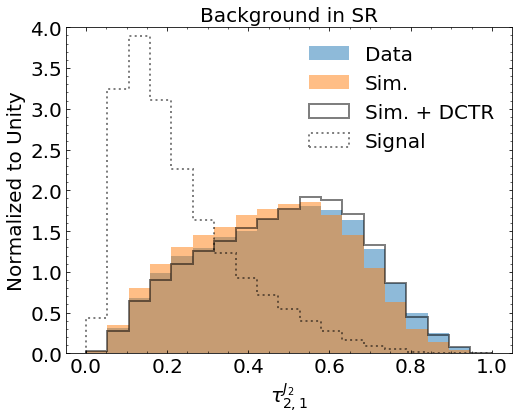

In [23]:
x = X_SALAD_sr_train
y = Y_SALAD_sr_train
sig = X_SALAD_val[Y_SALAD_val == 1]
w = W_SALAD_sr_train

for i in range(1,5):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.xlabel(column_labels[i],fontsize=20)
    plt.ylabel("Normalized to Unity",fontsize=20)
    plt.title("Background in SR",fontsize=20)
    if i == 2 or i == 1:
        bins = np.linspace(0, 1., 20)
    else:
        bins = np.linspace(0, 1, 20)
    if (i==4): plt.ylim([0,4.])
    if (i==2): plt.ylim([0,9.2])
    if (i==3): plt.ylim([0,4])

    plt.hist(x[y == 1][:,i],bins=bins,alpha=0.5,density=True,label="Data")
    plt.hist(x[y == 0][:,i],bins=bins,alpha=0.5,density=True,label="Sim.")
    plt.hist(x[y == 0][:,i],bins=bins,alpha=0.5,weights=w[y==0],density=True,histtype="step",color="black",label="Sim. + DCTR",linewidth=2)
    plt.hist(sig[:,i],bins=bins,alpha=0.5,density=True,label="Signal",histtype="step",color="black",ls=":",linewidth=2)
    plt.legend(frameon=False,fontsize=20)
    if (i==2): plt.legend(frameon=False,fontsize=20,loc="upper left")
    plt.savefig('plots/lhco/features'+str(i)+'_deltamj_extracorr.pdf',bbox_inches='tight')

## data vs. simulation
SR only

In [24]:
import tqdm

#Now let's do data versus sim
dvsim_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
    
    X_dvsim_train = np.concatenate([SR_signal_to_inject, SR_background_data, SR_background_sim])
    Y_dvsim_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_sim))])

    X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

    X_dvsim_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_dvsim_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    # average over 5 models

    K.clear_session()
    model_dvsim = Sequential()
    model_dvsim.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(1, activation='sigmoid'))
    model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_dvsim = model_dvsim.fit(X_dvsim_train[:,1:], Y_dvsim_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)

    scores_dvsim = model_dvsim.predict(X_dvsim_val[:,1:],batch_size=batch_size)
        
    fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)
    dvsim_rocs = dvsim_rocs.append({'fpr': fpr_dvsim, 'tpr': tpr_dvsim}, ignore_index=True)

100%|██████████| 20/20 [17:38<00:00, 52.93s/it]


## Optimal CWoLa


In [25]:
#Now let's optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ocwola_train = np.concatenate([SR_signal_to_inject, SR_background_data,SR_background_data_fortest])
    Y_ocwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_data_fortest))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    sbmjj = X_ocwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ocwola_train = X_ocwola_train[sb_crit]
    Y_ocwola_train = Y_ocwola_train[sb_crit]

    X_ocwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])


    K.clear_session()
    model_ocwola = Sequential()
    model_ocwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(1, activation='sigmoid'))
    model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_ocwola = model_ocwola.fit(X_ocwola_train[:,1:], Y_ocwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)

    scores_ocwola = model_ocwola.predict(X_ocwola_val[:,1:],batch_size=batch_size)
    
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

100%|██████████| 20/20 [17:33<00:00, 52.69s/it]


## CWoLa

In [26]:
#Next is CWoLa
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
        
    X_cwola_train = np.concatenate([SR_signal_to_inject, SR_background_data, SB_signal_to_inject, SB_background_data])
    Y_cwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.ones(len(SR_background_data)),
                                    np.zeros(len(SB_signal_to_inject)), np.zeros(len(SB_background_data))])
    
    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train, )

    sbmjj = X_cwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_cwola_train = X_cwola_train[sb_crit]
    Y_cwola_train = Y_cwola_train[sb_crit]
    
    w_low = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] <= SR_low).sum())
    w_high = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] >= SR_high).sum())

    W_cwola_train = np.ones_like(Y_cwola_train)
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] <= SR_low)] = w_low
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] >= SR_high)] = w_high
    
    X_cwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(X_cwola_train[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)

    scores_cwola = model_cwola.predict(X_cwola_val[:,1:],batch_size=batch_size)
        
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

100%|██████████| 20/20 [23:15<00:00, 69.76s/it]


## SA-CWoLa: no hyperparameter

the new one that kees came up with

lambda = N_data_SR/N_sim_SR

mean tends to look nicer, use mean. Also just save k-SA-cwola. And also add salad as purple
"LHCO example" at top
error bands/broken down in appendix
supervised case in appendix

In [27]:
#Next is SA-CWoLa
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ksacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ksacwola_train = np.concatenate([
        SR_signal_to_inject, SB_signal_to_inject[SB_signal_to_inject[:,0] < SR_low], SB_signal_to_inject[SB_signal_to_inject[:,0] > SR_high],
        SR_background_data, SB_background_data[SB_background_data[:,0] < SR_low], SB_background_data[SB_background_data[:,0] > SR_high],
        SR_background_sim, SB_background_sim[SB_background_sim[:,0] < SR_low], SB_background_sim[SB_background_sim[:,0] > SR_high]
    ])
    Y_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), np.zeros(len(SB_signal_to_inject)),
        np.ones(len(SR_background_data)), np.zeros(len(SB_background_data)),
        np.zeros(len(SR_background_sim)), np.ones(len(SB_background_sim))
    ])
        
    n_low_data = ((SB_background_data[:,0] > (SR_low - SB_width)) & ((SB_background_data[:,0] <= SR_low))).sum()
    n_low_sim = ((SB_background_sim[:,0] > (SR_low - SB_width)) & ((SB_background_sim[:,0] <= SR_low))).sum()
    n_low_sig = ((SB_signal_to_inject[:,0] > (SR_low - SB_width)) & ((SB_signal_to_inject[:,0] <= SR_low))).sum()

    n_hi_data = ((SB_background_data[:,0] < (SR_high + SB_width)) & ((SB_background_data[:,0] >= SR_high))).sum()
    n_hi_sim = ((SB_background_sim[:,0] < (SR_high + SB_width)) & ((SB_background_sim[:,0] >= SR_high))).sum()
    n_hi_sig = ((SB_signal_to_inject[:,0] < (SR_high + SB_width)) & ((SB_signal_to_inject[:,0] >= SR_high))).sum()

    n_sr_data = len(SR_background_data)
    n_sr_sim = len(SR_background_sim)
    n_sr_sig = len(SR_signal_to_inject)
        
    
    w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
    w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)
    
    w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
    w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
    
    
    
    W_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), w_low*np.ones((SB_signal_to_inject[:,0] <= SR_low).sum()), w_high*np.ones((SB_signal_to_inject[:,0] > SR_high).sum()),
        np.ones(len(SR_background_data)), w_low*np.ones((SB_background_data[:,0] <= SR_low).sum()), w_high*np.ones((SB_background_data[:,0] > SR_high).sum()),
        myklambda*np.ones(len(SR_background_sim)), w_low_sim*myklambda*np.ones((SB_background_sim[:,0] <= SR_low).sum()), w_high_sim*myklambda*np.ones((SB_background_sim[:,0] > SR_high).sum())
    ])
    
    sbmjj = X_ksacwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ksacwola_train = X_ksacwola_train[sb_crit]
    Y_ksacwola_train = Y_ksacwola_train[sb_crit]
    W_ksacwola_train = W_ksacwola_train[sb_crit]
    
    
    X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train = shuffle(X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train)

    
    X_ksacwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ksacwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_ksacwola = Sequential()
    model_ksacwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(1, activation='sigmoid'))
    model_ksacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_ksacwola = model_ksacwola.fit(X_ksacwola_train[:,1:], Y_ksacwola_train, epochs=EPOCHS, 
                                     batch_size=batch_size,sample_weight=W_ksacwola_train,
                                     verbose=0
                                    )

    scores_ksacwola = model_ksacwola.predict(X_ksacwola_val[:,1:],batch_size=batch_size)
    
    fpr_ksacwola, tpr_ksacwola, _ = roc_curve(Y_ksacwola_val, scores_ksacwola)
    ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)

100%|██████████| 20/20 [45:51<00:00, 137.57s/it]


In [28]:
with np.errstate(divide='ignore'):
    # data v sim
    tpr_pts = np.linspace(0, 1, 10000)

    fpr_interp = [None] * len(dvsim_rocs)

    for i, row in dvsim_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    dvsim_max = np.nanmax(fpr_interp, axis=0).data
    dvsim_min = np.nanmin(fpr_interp, axis=0).data
    dvsim_med = np.median(fpr_interp, axis=0).data
    dvsim_mean = np.nanmean(fpr_interp, axis=0).data
    dvsim_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    dvsim_smean = np.nanmean(sig_interp, axis=0).data
    dvsim_sstd = np.nanstd(sig_interp, axis=0).data
    
    # autoencoder
    fpr_interp = [None] * len(ae_rocs)
    
    for i, row in ae_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ae_max = np.nanmax(fpr_interp, axis=0).data
    ae_min = np.nanmin(fpr_interp, axis=0).data
    ae_med = np.median(fpr_interp, axis=0).data
    ae_mean = np.nanmean(fpr_interp, axis=0).data
    ae_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ae_smean = np.nanmean(sig_interp, axis=0).data
    ae_sstd = np.nanstd(sig_interp, axis=0).data

    # optimal CWoLa
    fpr_interp = [None] * len(ocwola_rocs)
    
    for i, row in ocwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ocwola_max = np.nanmax(fpr_interp, axis=0).data
    ocwola_min = np.nanmin(fpr_interp, axis=0).data
    ocwola_med = np.median(fpr_interp, axis=0).data
    ocwola_mean = np.nanmean(fpr_interp, axis=0).data
    ocwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ocwola_smean = np.nanmean(sig_interp, axis=0).data
    ocwola_sstd = np.nanstd(sig_interp, axis=0).data

    # CWoLa
    fpr_interp = [None] * len(cwola_rocs)

    for i, row in cwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_max = np.nanmax(fpr_interp, axis=0).data
    cwola_min = np.nanmin(fpr_interp, axis=0).data
    cwola_med = np.median(fpr_interp, axis=0).data
    cwola_mean = np.nanmean(fpr_interp, axis=0).data
    cwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smean = np.nanmean(sig_interp, axis=0).data
    cwola_sstd = np.nanstd(sig_interp, axis=0).data


    # k-SA-CWoLa
    fpr_interp = [None] * len(ksacwola_rocs)

    for i, row in ksacwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ksacwola_max = np.nanmax(fpr_interp, axis=0).data
    ksacwola_min = np.nanmin(fpr_interp, axis=0).data
    ksacwola_med = np.median(fpr_interp, axis=0).data
    ksacwola_mean = np.nanmean(fpr_interp, axis=0).data
    ksacwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ksacwola_smean = np.nanmean(sig_interp, axis=0).data
    ksacwola_sstd = np.nanstd(sig_interp, axis=0).data
    
    fpr_interp = [None] * len(SALAD_rocs)

    for i, row in SALAD_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    SALAD_max = np.nanmax(fpr_interp, axis=0).data
    SALAD_min = np.nanmin(fpr_interp, axis=0).data
    SALAD_med = np.median(fpr_interp, axis=0).data
    SALAD_mean = np.nanmean(fpr_interp, axis=0).data
    SALAD_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    SALAD_smean = np.nanmean(sig_interp, axis=0).data
    SALAD_sstd = np.nanstd(sig_interp, axis=0).data

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## save bandings

In [71]:
import pickle

LOAD = True
SAVE = False

band_path = 'plots/lhco/bands_corr_deltamj_extracorr.pkl'

if LOAD:
    with open(band_path, 'rb') as f:
        bands = pickle.load(f)
        tpr_pts = np.linspace(0, 1, 10000)

else:
    bands = {'ocwola': (ocwola_max, ocwola_med, ocwola_min, ocwola_mean, ocwola_std, ocwola_smean, ocwola_sstd, {'label':'Optimal CWoLa', 'color':'red'}),
             'dvsim': (dvsim_max, dvsim_med, dvsim_min, dvsim_mean, dvsim_std, dvsim_smean, dvsim_sstd, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
             'autoencoder': (ae_max, ae_med, ae_min, ae_mean, ae_std, ae_smean, ae_sstd, {'label':"Autoencoder".format(myklambda), 'color':'blue'}),
             'cwola': (cwola_max, cwola_med, cwola_min, cwola_mean, cwola_std, cwola_smean, cwola_sstd, {'label':'CWoLa', 'color':'red', 'ls':':'}),
             'SALAD': (SALAD_max, SALAD_med, SALAD_min, SALAD_mean, SALAD_std, SALAD_smean, SALAD_sstd, {'label':'SALAD', 'color':'tab:purple'}),
             'sacwola': (ksacwola_max, ksacwola_med, ksacwola_min, ksacwola_mean, ksacwola_std, ksacwola_smean, ksacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(myklambda), 'color':'orange'}),
            }
if SAVE:
    with open(band_path, 'wb') as f:
        pickle.dump(bands, f)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


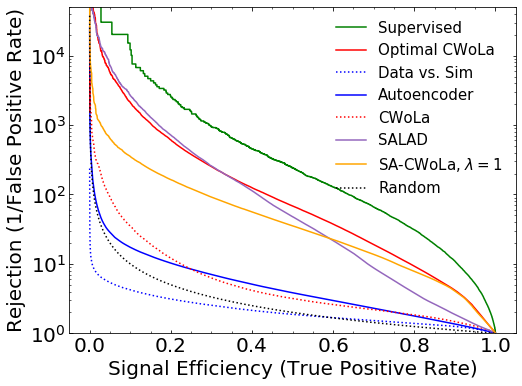

In [72]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
plt.savefig('plots/lhco/combined_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
plt.savefig('plots/lhco/combined_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')
# plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


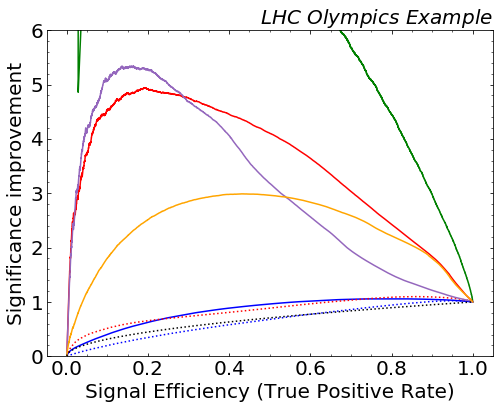

In [73]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ERR = False

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([0, 6])

plt.plot(tpr_sup,tpr_sup/np.sqrt(fpr_sup),label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][5:7]
    plt.plot(tpr_pts, tpr_pts*mu, **bands[band][-1])
plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance improvement",fontsize=20)
plt.title(r'$LHC$ $Olympics$ $Example$', loc='right', fontsize=20)

plt.savefig('plots/lhco/combined_relsigs_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
plt.savefig('plots/lhco/combined_relsigs_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


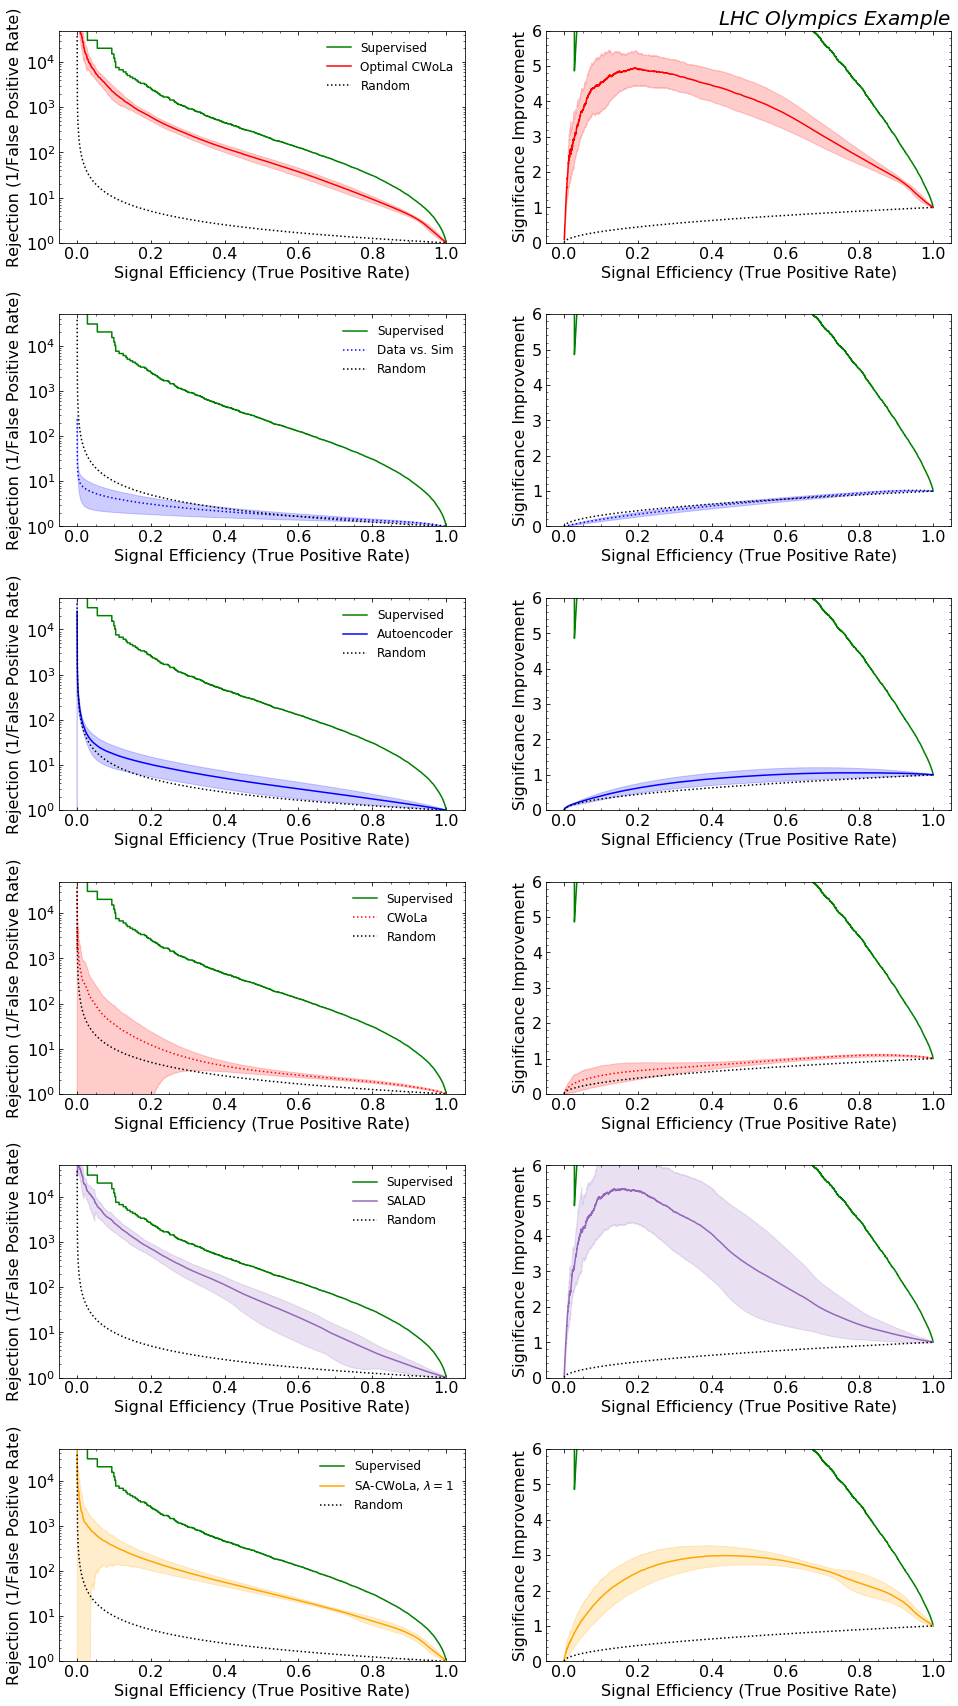

In [74]:
 # Plot individual bands

STD = True

band_names = [k for k in bands.keys() if k not in ['old-sacwola', 'hl-sacwola']]

fig = plt.figure(figsize=(16, 5*len(band_names))) 
gs = gridspec.GridSpec(len(band_names)*2 - 1, 2, height_ratios=[1, 0.1,]*(len(band_names) - 1) + [1,])


for i, key in enumerate(band_names):
    line_max, line_med, line_min, line_mean, line_std, line_smean, line_sstd, opt = bands[key]
    for j in range(2):

        ax0 = plt.subplot(gs[2*i, j])

        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        ax0.minorticks_on()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        
        if j == 0:
            plt.ylim([1,5*1e4])
            plt.yscale("log")
            plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
            plt.plot(tpr_pts, line_mean, **opt)
            plt.fill_between(tpr_pts, line_mean - line_std, line_mean + line_std, color=opt['color'], alpha=0.2)        
            plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")
            plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
            plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
            plt.legend(frameon=False,fontsize=12,loc="upper right")
        else:
            plt.ylim([0, 6])
            plt.plot(tpr_sup,tpr_sup/np.sqrt(fpr_sup),label="Supervised",color='green')
            plt.plot(tpr_pts, tpr_pts*line_smean, **opt)
            plt.fill_between(tpr_pts, tpr_pts*(line_smean - line_sstd), tpr_pts*(line_smean + line_sstd), color=opt['color'], alpha=0.2)        
            plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")
            plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
            plt.ylabel(r"Significance Improvement",fontsize=16)
            if i == 0:
                plt.title('$LHC$ $Olympics$ $Example$', fontsize=20, loc='right')
                
plt.savefig('plots/lhco/separate_corr_deltamj_extracorr.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/lhco/separate_corr_deltamj_extracorr.pdf', bbox_inches='tight', padinches=0)
